# Twitter Sentiment Analysis / Clasiffication Model analysis

### Data Description
The dataset being used is the <a href="https://www.kaggle.com/kazanova/sentiment140" target="_blank">sentiment140</a> dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

#### Data Details
It contains the following 6 fields: 
* **sentiment**: the polarity of the tweet (0 = negative, 4 = positive)
* **ids**: The id of the tweet (2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

#### Add additional description 

### Import necessary libraries

In [1]:
# DataFrame
import numpy as np
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# nltk

# Scikit-learn
from sklearn.model_selection import train_test_split

### Import Data

In [2]:
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df_encoding = 'latin-1'

In [3]:
df_raw = pd.read_csv('Data/training.1600000.processed.noemoticon.csv', names = columns, header= None, encoding= df_encoding)

### EDA

In [4]:
df_raw.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
print("Dataset size:", len(df_raw))

Dataset size: 1600000


In [6]:
print(df_raw['text'][0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


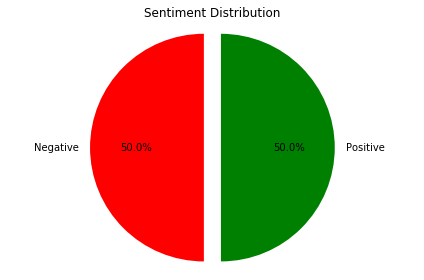

In [7]:
# sum the instances of males and females
negative = (df_raw['target'] == 0).sum()
positive = (df_raw['target'] == 4).sum()

# put them into a list called proportions
proportions = [negative, positive]

# Create a pie chart
plt.pie(
    # using proportions
    proportions,
    
    # with the labels being officer names
    labels = ['Negative', 'Positive'],
    
    # with no shadows
    shadow = False,
    
    # with colors
    colors = ['red','green'],
    
    # with one slide exploded out
    explode = (0.15 , 0),
    
    # with the start angle at 90%
    startangle = 90,
    
    # with the percent listed as a fraction
    autopct = '%1.1f%%'
    )

# View the plot drop above
plt.axis('equal')

# Set labels
plt.title("Sentiment Distribution")

# View the plot
plt.tight_layout()
plt.show()

### Data Cleaning

In [15]:
# Remove unnecessary columns
df = df_raw[['target', 'text']]

# Replace a value for positive tweets
df['target'].replace(to_replace = 4, value =1, inplace=True)

In [9]:
df['target'].value_counts()

1    800000
0    800000
Name: target, dtype: int64

Before we learn too much about the data, we will split it into a training set and a test set.

In [10]:
text, sentiment = list(df['text']), list(df['target'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(text, sentiment, test_size=0.2, random_state=42)

In [12]:
X =  list(range(15))
print (X)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [13]:
y = [x * x for x in X]
print (y)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.65,test_size=0.35, random_state=101)
print ("X_train: ", X_train)
print ("y_train: ", y_train)
print("X_test: ", X_test)
print ("y_test: ", y_test)

X_train:  [0, 14, 4, 8, 9, 7, 6, 1, 11]
y_train:  [0, 196, 16, 64, 81, 49, 36, 1, 121]
X_test:  [13, 2, 3, 12, 10, 5]
y_test:  [169, 4, 9, 144, 100, 25]


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class TweetToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True, replace_numbers=True):
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_numbers = replace_numbers
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)            

In [ ]:
def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)